In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tic_env import TictactoeEnv, OptimalPlayer
from performance_measures import M_opt, M_rand

$M_{\mathrm{opt}}$ measures the performance of $\pi$ against the optimal policy. <br>
To compute $M_{\mathrm{opt}}$, we run $\pi$ against `Opt(0)` for `N = 500` games for different random seeds. <br>
$\pi$ makes the 1st move in 250 games, and `Opt(0)` makes the 1st move in the rest. <br>
We count how many games $\pi$ wins ($N_{\mathrm{win}}$) and loses ($N_{\mathrm{loss}}$) and define $$M_{\mathrm{opt}} = \frac{N_{\mathrm{win}} - N_{\mathrm{loss}}}{N}$$.

$M_{\mathrm{rand}}$ measures the performance of against the random policy. <br>
To compute $M_{\mathrm{rand}}$, we repeat what we did for computing $M_{\mathrm{opt}}$ but by using `Opt(1)` instead of `Opt(0)`.

In [3]:
def M(policy, epsilon, N):
    env = TictactoeEnv()
    opponent = OptimalPlayer(epsilon=epsilon)

    N_win, N_loss, N_draw = 0, 0, 0
    for iteration in range(N):
        env.reset()
        grid, end, _ = env.observe()

        if iteration < N // 2:
            policy_player = "X"
            opponent_player = "O"
        elif iteration >= N // 2:
            policy_player = "O"
            opponent_player = "X"
        
        opponent.set_player(opponent_player)
        if isinstance(policy, OptimalPlayer):
            policy.set_player(policy_player)

        while not end:
            
            if env.current_player == opponent.player:
                move = opponent.act(grid)
            else:
                move = policy.act(grid)

            grid, end, winner = env.step(move)
        
        if winner == policy_player:
            N_win += 1
        elif winner == opponent_player:
            N_loss += 1
        else:
            N_draw += 1
    
    return (N_win - N_loss) / N

def M_opt(policy, N=500):
    return M(policy, 0, N)

def M_rand(policy, N=500):
    return M(policy, 1, N)

In [4]:
p = OptimalPlayer(0)
print("M_opt: ", M_opt(p), ", M_rand: ", M_rand(p))

M_opt:  0.0 , M_rand:  0.906


## Q-Learning combined with epsilon-greedy policy. 

We start by creating a data structure to save our Q values

In [15]:
# Stores only one value that it returns on any key
class FinalState():
    def __init__(self):
        self.value = 0
    def __getitem__(self, key):
        return self.value
    def __setitem__(self, key, value):
        self.value = value
    def values(self):
        return [self.value]
    def __repr__(self):
        return "{any: " + str(self.value) + "}"

# Q_table[state][move]
class QTable(dict):
    def __getitem__(self, key):
        self.__check_key(key)
        return super().__getitem__(self.__to_tuple(key))
    def __setitem__(self, key, value):
        self.__check_key(key)
        super().__setitem__(self.__to_tuple(key), value)

    def __missing__(self, key):
        arr = self.__to_array(key)
        non_zero_locations = list(zip(*np.nonzero(arr == 0)))

        # check if game has ended
        if (len(non_zero_locations) == 0 or # check if all the positions are filled
            np.any(np.sum(arr, axis=0) == 3) or # check rows and cols
            np.any(np.sum(arr, axis=1) == 3) or
            np.any(np.sum(arr, axis=0) == -3) or 
            np.any(np.sum(arr, axis=1) == -3) or
            arr[[0,1,2],[0,1,2]].sum() == 3 or # check diagnols
            arr[[0,1,2],[2,1,0]].sum() == 3 or 
            arr[[0,1,2],[0,1,2]].sum() == -3 or 
            arr[[0,1,2],[2,1,0]].sum() == -3):
            ret = self[arr] = FinalState()
            return ret
        ret = self[arr] = {loc: 0 for loc in non_zero_locations}
        return ret

    def __check_key(self, key):
        if not isinstance(key, np.ndarray):
            raise(TypeError("QTable only accepts np.ndarray of as keys"))
        if key.shape != (3, 3):
            raise(ValueError("QTable only accepts np.ndarray of shape (3, 3)"))
    def __to_array(self, key):
        if isinstance(key, tuple):
            key = np.array(key).reshape(3, 3)
        return key
    def __to_tuple(self, key):
        if isinstance(key, np.ndarray):
            key = tuple(key.reshape(-1))
        return key

In [16]:
class EpsilonGreedy:
    def __init__(self, epsilon=0):
        self.epsilon = epsilon
    
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
    
    def act(self, state):
        Q_actions = Q_table[state]
        if np.random.random() < self.epsilon:
            actions = list(Q_actions.keys())
            if len(actions) == 1:
                return actions[0]
            return actions[np.random.randint(0, len(actions)-1)]
        else:
            return max(Q_actions, key=Q_actions.get)

At each time $t$, state $s_t$ is the board position, action $a_t$ is one of the available positions on the board and reward $r_t$. <br>
The reward only non-zero when the game ends where you get $r_t = 1$ if you win the game, $r_t = 1$ if you lose, and $r_t=0$ if it is a draw.

Q-Learning has 3 hyper-parameters: 
- learning rate $\alpha$
- discount factor $\gamma$
- and exploration level $\epsilon$ 

For convenience, we fix the learning rate at alpha = 0.05 and the discount factor at $\gamma$ = 0.99. <br>
We initialize all the Q-values at 0. <br>
If you are curious, you can explore the effect of $\alpha$, $\gamma$ and initial Q-values for yourself. <br>

In [17]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon = 0.1 # exploration rate

### 2.1 Learning from experts

In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against `Opt(`$\epsilon_{opt}$`)` for some $\epsilon_{opt} \in [0; 1]$. <br> 
To do so, implement the Q-learning algorithm. To check the algorithm, run a Q-learning agent, with a fixed and arbitrary $\epsilon_{opt} \in [0; 1)$ against `Opt(0.5)` for 20'000 games. <br> 
Switch the 1st player after every game.

In [18]:
env = TictactoeEnv()
Q_table = QTable()
rewards = []
num_trained_games = 0
av_rewards = []

policy = EpsilonGreedy(epsilon=epsilon)

In [ ]:
num_games = 20000
opponent_player = OptimalPlayer(0.5, player='O')
learning_player = 'X'
rewards = []

for itr in range(num_games):
    env.reset()
    state, end, _ = env.observe()

    opponent_player.player, learning_player = learning_player, opponent_player.player

    if opponent_player.player == 'X':
        opponent_move = opponent_player.act(state)
        state, end, _ = env.step(opponent_move)

    while not end:
        move = policy.act(state)
        next_state, end, _ = env.step(move)

        if (not end) and (env.current_player == opponent_player.player):
            opponent_move = opponent_player.act(next_state)
            next_state, end, _ = env.step(opponent_move)
        
        reward = env.reward(player=learning_player)
            
        if end:
            Q_table[next_state][[]] = reward
        
        Q_table[state][move] = Q_table[state][move] + alpha * (reward + gamma * max(Q_table[next_state].values()) - Q_table[state][move])

        state = next_state

    rewards.append(reward)
    if len(rewards) >= 250:
        av_rewards.append(np.mean(rewards))
        rewards = []
        clear_output(wait=True)
        plt.plot(av_rewards)
        plt.show()
    num_trained_games += 1
    env.reset()

In [26]:
print("M_opt: ", M_opt(policy), ", M_rand: ", M_rand(policy))

M_opt:  -0.166 , M_rand:  0.684


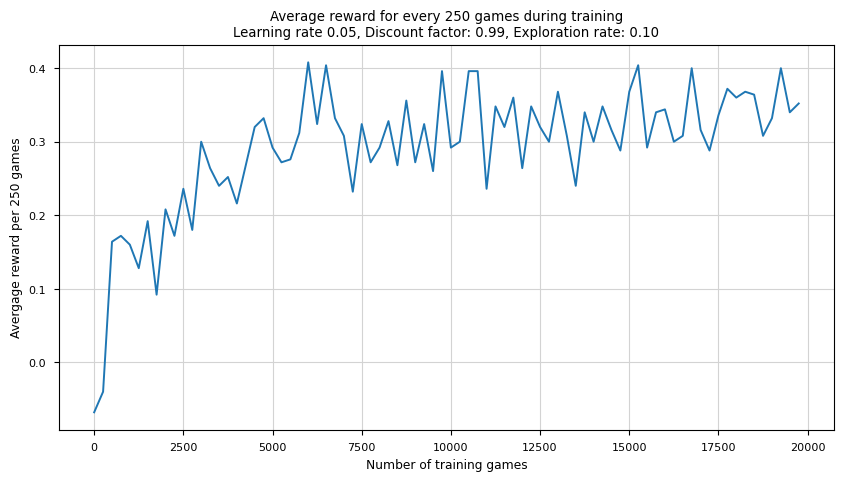

In [30]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, num_trained_games, 250), av_rewards, "-")
plt.title(f"Average reward for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f}, Exploration rate: {epsilon:.2f}")
plt.ylabel("Avergage reward per 250 games")
plt.xlabel("Number of training games")
plt.grid(color="lightgrey")
plt.show()

### 2.1.1 Decreasing exploration

One way to make training more efficient is to decrease the exploration level $\epsilon$ over time. If we define $\epsilon(n)$ to be $\epsilon$ for game number $n$, then one feasible way to decrease exploration during training is to use
$$
\epsilon(n)=\max \left\{\epsilon_{\min }, \epsilon_{\max }\left(1-\frac{n}{n^{*}}\right)\right\}
$$
where $\epsilon_{\min }$ and $\epsilon_{\max }$ are the minimum and maximum values for $\epsilon$, respectively, and $n^{*}$ is the number of exploratory games and shows how fast $\epsilon$ decreases. For convenience, we assume $\epsilon_{\min }=0.1$ and $\epsilon_{\max }=0.8$; if you are curious, you can explore their effect on performance for yourself. Use $\epsilon(n)$ as define above and run different $Q$-learning agents with different values of $n^{*}$ against `Opt(0.5)` for 20'000 games - switch the 1st player after every game. Choose several values of $n^{*}$ from a reasonably wide interval between 1 to $40^{\prime} 000$ - particularly, include $n^{*}=1$.


In [14]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon_min, epsilon_max = 0.1, 0.8 # exploration rate

In [23]:
class EpsilonGreedyDecreasingExploration(EpsilonGreedy):

    def __init__(self, epsilon_min= 0.1, epsilon_max=0.8, n_star=20000):
        super().__init__()
        self.epsilon_min = epsilon_min
        self.epsilon_max = epsilon_max
        self.n_star = n_star

    def update_epsilon(self, n):
        new_epsilon = max(self.epsilon_min, self.epsilon_max * (1 - (n / self.n_star)))
        self.set_epsilon(epsilon=new_epsilon)

In [35]:
av_rewards_dict = {}
m_opt_dict = {}
m_rand_dict = {}

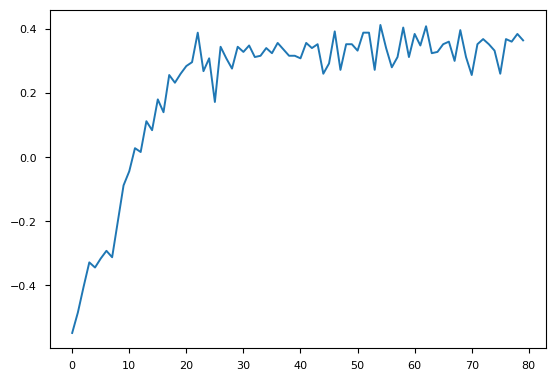

In [57]:
num_games = 20000

for n_star in (5000,):
    rewards = []
    opponent_player = OptimalPlayer(0.5, player='O')
    learning_player = 'X'
    av_rewards = []
    m_opt_list = []
    m_rand_list = []
    policy = EpsilonGreedyDecreasingExploration(epsilon_min=epsilon_min, 
                                                epsilon_max=epsilon_max, 
                                                n_star=n_star)
    env = TictactoeEnv()
    Q_table = QTable()
    rewards = []
    num_trained_games = 0
    av_rewards = []

    for itr in range(num_games):
        env.reset()
        state, end, _ = env.observe()

        opponent_player.player, learning_player = learning_player, opponent_player.player

        if opponent_player.player == 'X':
            opponent_move = opponent_player.act(state)
            state, end, _ = env.step(opponent_move)

        while not end:
            policy.update_epsilon(itr)
            move = policy.act(state)
            next_state, end, _ = env.step(move)

            if (not end) and (env.current_player == opponent_player.player):
                opponent_move = opponent_player.act(next_state)
                next_state, end, _ = env.step(opponent_move)
            
            reward = env.reward(player=learning_player)
                
            if end:
                Q_table[next_state][[]] = reward
            
            Q_table[state][move] = Q_table[state][move] + alpha * (reward + gamma * max(Q_table[next_state].values()) - Q_table[state][move])

            state = next_state

        rewards.append(reward)
        if len(rewards) >= 250:
            av_rewards.append(np.mean(rewards))
            rewards = []
            clear_output(wait=True)
            plt.plot(av_rewards)
            plt.show()
            policy.set_epsilon(0)
            m_opt_list.append(M_opt(policy))
            m_rand_list.append(M_rand(policy))
        num_trained_games += 1
        env.reset()
    av_rewards_dict[n_star] = av_rewards
    m_opt_dict[n_star] = m_opt_list
    m_rand_dict[n_star] = m_rand_list

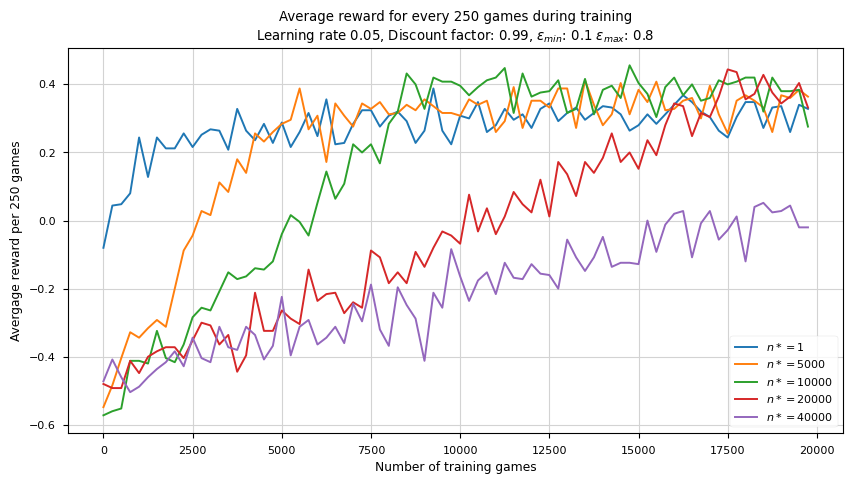

In [63]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
for n_star, av_rewards in sorted(av_rewards_dict.items()):
    plt.plot(np.arange(0, num_trained_games, 250), av_rewards, "-", label=f"$n*={n_star}$")
plt.title(f"Average reward for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f},"+" $\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("Avergage reward per 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

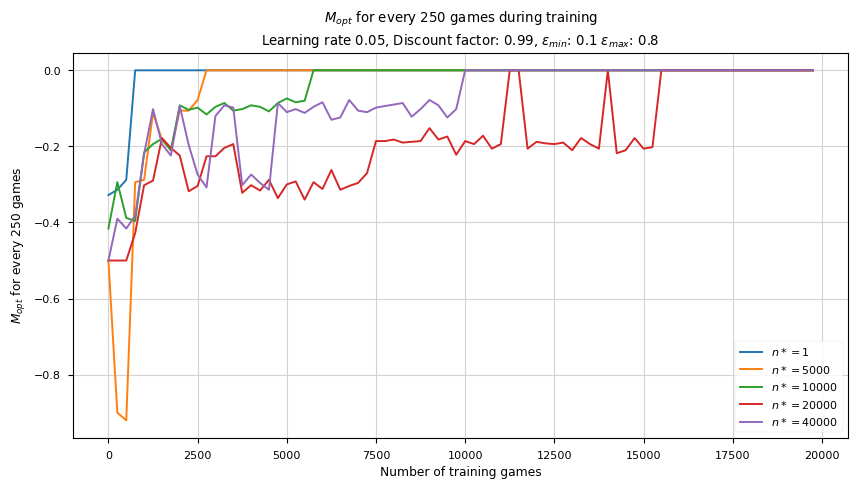

In [64]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')
plt.figure(figsize=(10, 5))
for n_star, m_opt_list in sorted(m_opt_dict.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_opt_list, "-", label=f"$n*={n_star}$")
plt.title("$M_{opt}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f},"+" $\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{opt}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

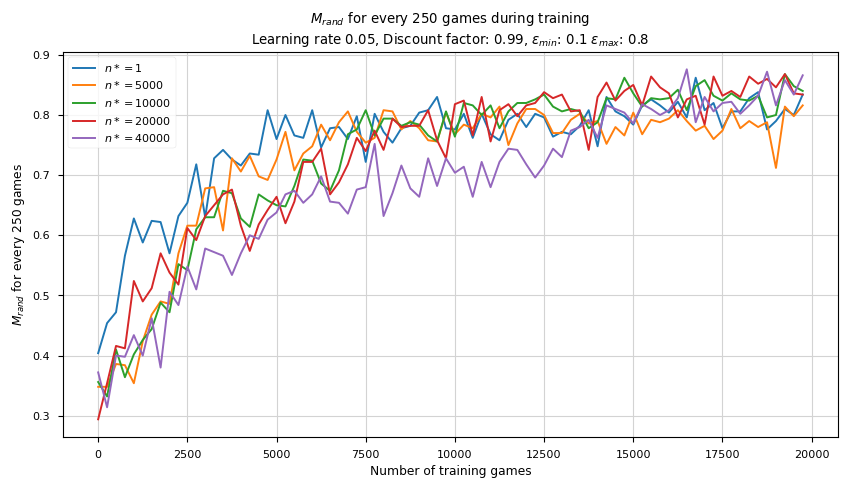

In [65]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
for n_star, m_rand_list in sorted(m_rand_dict.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_rand_list, "-", label=f"$n*={n_star}$")
plt.title("$M_{rand}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f},"+" $\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{rand}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

### 2.1.2 Good experts and bad experts
Choose the best value of $n^{*}$ that you found in the previous section. Run $Q$-learning against Opt $\left(\epsilon_{\mathrm{opt}}\right)$ for different values of $\epsilon_{\mathrm{opt}}$ for 20 '000 games $-$ switch the 1st player after every game. Choose several values of $\epsilon_{\mathrm{opt}}$ from a reasonably wide interval between 0 to $1-$ particularly, include $\epsilon_{\mathrm{opt}}=0$.

In [24]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon_min, epsilon_max = 0.1, 0.8 # exploration rate

In [25]:
m_opt_per_epsilon = {}
m_rand_per_epsilon = {}

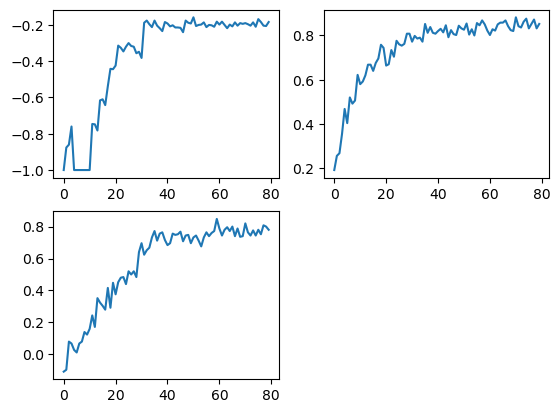

In [26]:
n_star = 10000
num_games = 20000

for epsilon_opt in (0, 0.25, 0.50, 0.75, 1.0):
    rewards = []
    opponent_player = OptimalPlayer(epsilon_opt, player='O')
    learning_player = 'X'
    av_rewards = []
    m_opt_list = []
    m_rand_list = []
    policy = EpsilonGreedyDecreasingExploration(epsilon_min=epsilon_min, 
                                                epsilon_max=epsilon_max, 
                                                n_star=n_star)
    env = TictactoeEnv()
    Q_table = QTable()
    num_trained_games = 0

    for itr in range(num_games):
        env.reset()
        state, end, _ = env.observe()

        opponent_player.player, learning_player = learning_player, opponent_player.player

        if opponent_player.player == 'X':
            opponent_move = opponent_player.act(state)
            state, end, _ = env.step(opponent_move)

        while not end:
            policy.update_epsilon(itr)
            move = policy.act(state)
            next_state, end, _ = env.step(move)

            if (not end) and (env.current_player == opponent_player.player):
                opponent_move = opponent_player.act(next_state)
                next_state, end, _ = env.step(opponent_move)
            
            reward = env.reward(player=learning_player)
                
            if end:
                Q_table[next_state][[]] = reward
            
            Q_table[state][move] = Q_table[state][move] + alpha * (reward + gamma * max(Q_table[next_state].values()) - Q_table[state][move])

            state = next_state

        rewards.append(reward)
        if len(rewards) >= 250:
            av_rewards.append(np.mean(rewards))
            rewards = []
            policy.set_epsilon(0)
            m_opt_list.append(M_opt(policy))
            m_rand_list.append(M_rand(policy))
            clear_output(wait=True)
            plt.subplot(2, 2, 1)
            plt.plot(m_opt_list)
            plt.subplot(2, 2, 2)
            plt.plot(m_rand_list)
            plt.subplot(2, 2, 3)
            plt.plot(av_rewards)
            plt.show()
        num_trained_games += 1
        env.reset()
    m_opt_per_epsilon[epsilon_opt] = m_opt_list
    m_rand_per_epsilon[epsilon_opt] = m_rand_list

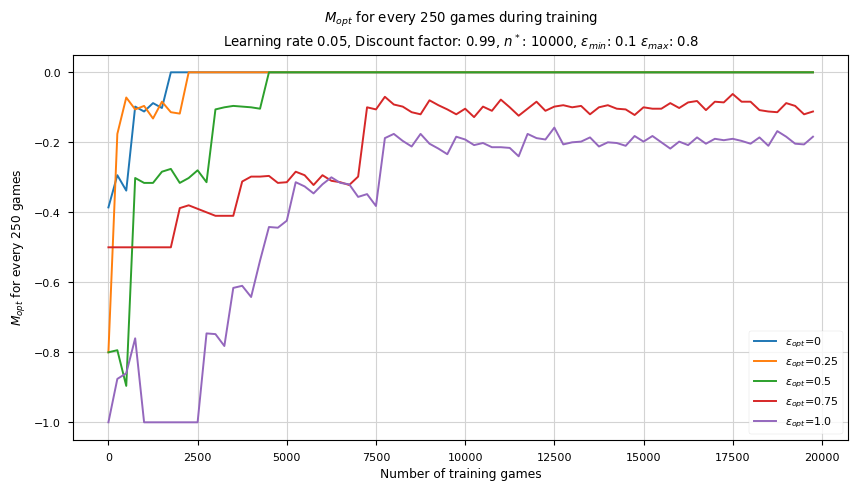

In [27]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
for e, m_opt_list in sorted(m_opt_per_epsilon.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_opt_list, "-", label="$\epsilon_{opt}$"+f"={e}")
plt.title("$M_{opt}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f}, $n^*$: {n_star}, "+"$\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{opt}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

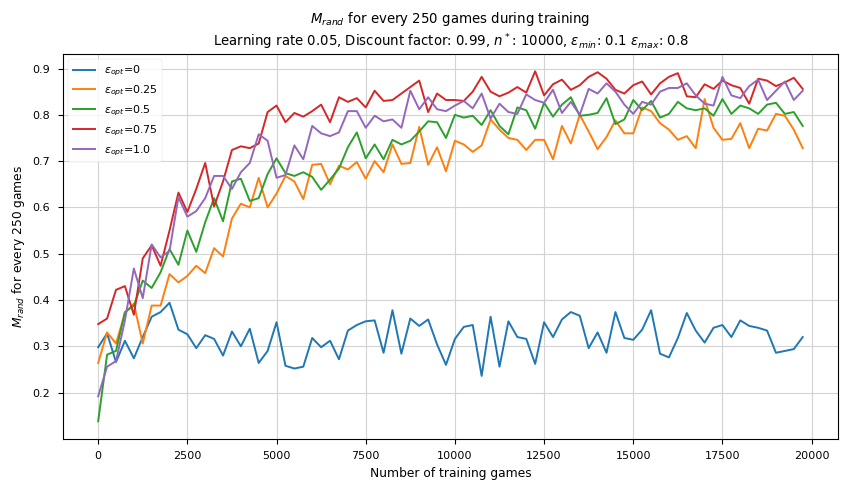

In [28]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
for e, m_rand_list in sorted(m_rand_per_epsilon.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_rand_list, "-", label="$\epsilon_{opt}$"+f"={e}")
plt.title("$M_{rand}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f}, $n^*$: {n_star}, "+"$\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{rand}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

In [100]:
max_m_opt = max(max(l) for l in m_opt_per_epsilon.values())
max_m_rand = max(max(l) for l in m_rand_per_epsilon.values())
max_m_opt, max_m_rand

(0.0, 0.882)

### 2.2 Learning by self-practice

In this section, your are supposed to ask whether $Q$-learning can learn to play Tic Tac Toe by only playing against itself. 

For different values of $\epsilon \in[0,1)$, run a $Q$-learning agent against itself for 20'000 games - i.e. both players use the same set of $Q$-values and update the same set of $Q$-values.

In [14]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor

In [15]:
m_opt_against_itself = {}
m_rand_against_itself = {}

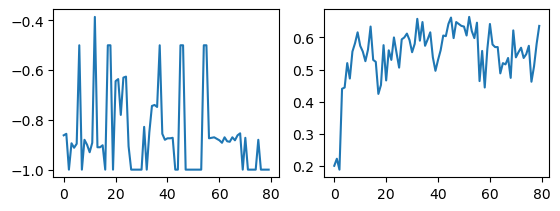

In [25]:
n_star = 10000
num_games = 20000

for epsilon in (1.0,):
    m_opt_list = []
    m_rand_list = []
    policy = EpsilonGreedy(epsilon=epsilon)
    env = TictactoeEnv()
    Q_table = QTable()
    num_trained_games = 0
    rewards_players1 = []
    avg_rewards_players1 = []
    for itr in range(num_games):
        env.reset()
        state0, end, _ = env.observe()

        current_player = 'X'
        next_player = 'O'

        move1 = policy.act(state0)
        state1, end, _ = env.step(move1)

        while not end:
            current_player, next_player = next_player, current_player

            move2 = policy.act(state1)
            state2, end, _ = env.step(move2)
            reward = env.reward(player = next_player)

            Q_table[state0][move1] =    Q_table[state0][move1] + alpha * (reward + gamma * max(Q_table[state2].values()) -
                                        Q_table[state0][move1])

            state0 = state1
            state1 = state2
            move1 = move2

        reward = env.reward(player = current_player)
        Q_table[state1][[]] = reward
        Q_table[state0][move1] =    Q_table[state0][move1] + alpha * (reward + gamma * max(Q_table[state1].values()) -
                                    Q_table[state0][move1])
        

        rewards_players1.append(env.reward(player = 'X'))
        if len(rewards_players1) >= 250:
            policy.set_epsilon(0)
            m_opt_list.append(M_opt(policy))
            m_rand_list.append(M_rand(policy))
            policy.set_epsilon(epsilon)
            avg_rewards_players1.append(np.mean(rewards_players1))
            rewards_players1 = []
            clear_output(wait=True)
            plt.subplot(2, 2, 1)
            plt.plot(m_opt_list)
            plt.subplot(2, 2, 2)
            plt.plot(m_rand_list)
            plt.show()

        num_trained_games += 1
        env.reset()
    m_opt_against_itself[epsilon] = m_opt_list
    m_rand_against_itself[epsilon] = m_rand_list

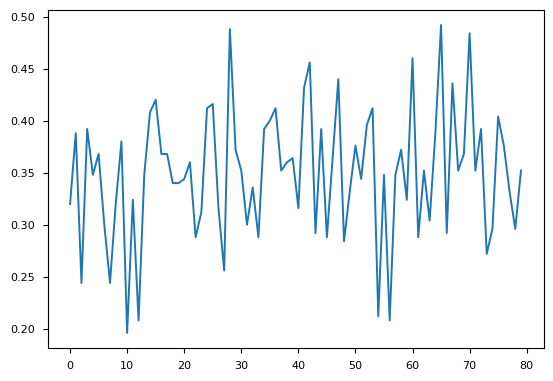

In [28]:
plt.plot(avg_rewards_players1)
plt.show()

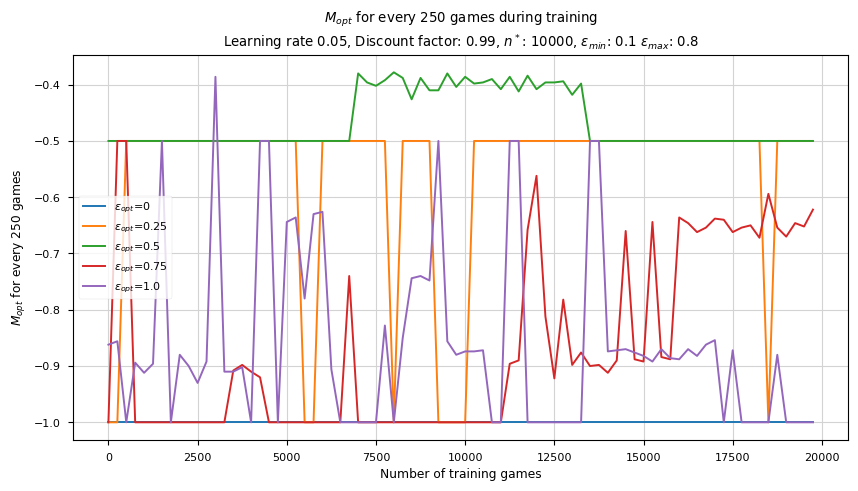

In [26]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
for e, m_opt_list in sorted(m_opt_against_itself.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_opt_list, "-", label="$\epsilon_{opt}$"+f"={e}")
plt.title("$M_{opt}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f}, $n^*$: {n_star}, "+"$\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{opt}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

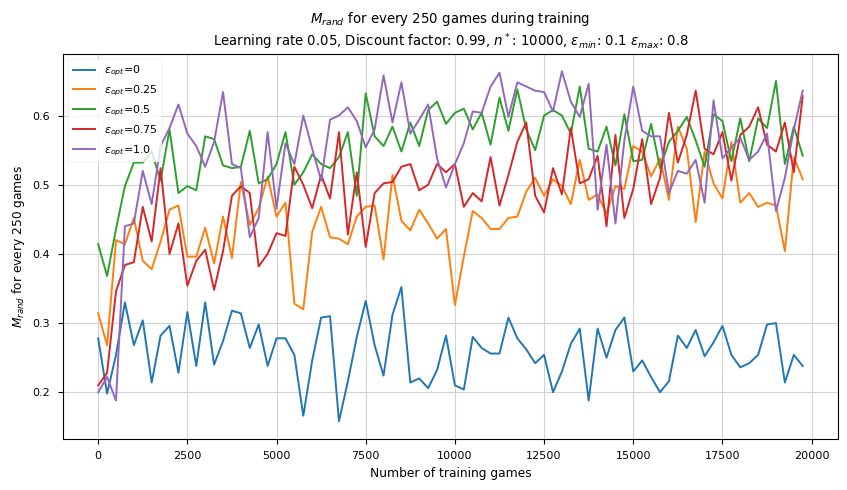

In [27]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
for e, m_rand_list in sorted(m_rand_against_itself.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_rand_list, "-", label="$\epsilon_{opt}$"+f"={e}")
plt.title("$M_{rand}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f}, $n^*$: {n_star}, "+"$\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{rand}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^*$ instead of fixing  $\epsilon$.

In [42]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon_min, epsilon_max = 0.1, 0.8 # exploration rate

In [43]:
av_rewards_dict = {}
m_opt_dict = {}
m_rand_dict = {}

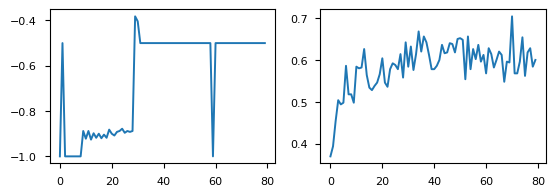

In [44]:
num_games = 20000

for n_star in (1, 5000, 10000, 20000, 40000):
    policy = EpsilonGreedyDecreasingExploration(epsilon_min=epsilon_min, 
                                                epsilon_max=epsilon_max, 
                                                n_star=n_star)
    env = TictactoeEnv()
    Q_table = QTable()
    rewards_players1 = []
    avg_rewards_players1 = []
    m_opt_list = []
    m_rand_list = []
    num_trained_games = 0
    for itr in range(num_games):
        env.reset()
        state0, end, _ = env.observe()

        current_player = 'X'
        next_player = 'O'
        
        policy.update_epsilon(itr)
        move1 = policy.act(state0)
        state1, end, _ = env.step(move1)

        while not end:
            current_player, next_player = next_player, current_player

            move2 = policy.act(state1)
            state2, end, _ = env.step(move2)
            reward = env.reward(player = next_player)

            Q_table[state0][move1] =    Q_table[state0][move1] + alpha * (reward + gamma * max(Q_table[state2].values()) -
                                        Q_table[state0][move1])

            state0 = state1
            state1 = state2
            move1 = move2

        reward = env.reward(player = current_player)
        Q_table[state1][[]] = reward
        Q_table[state0][move1] =    Q_table[state0][move1] + alpha * (reward + gamma * max(Q_table[state1].values()) -
                                    Q_table[state0][move1])
        

        rewards_players1.append(env.reward(player = 'X'))
        if len(rewards_players1) >= 250:
            policy.set_epsilon(0)
            m_opt_list.append(M_opt(policy))
            m_rand_list.append(M_rand(policy))
            avg_rewards_players1.append(np.mean(rewards_players1))
            rewards_players1 = []
            clear_output(wait=True)
            plt.subplot(2, 2, 1)
            plt.plot(m_opt_list)
            plt.subplot(2, 2, 2)
            plt.plot(m_rand_list)
            plt.show()
        num_trained_games += 1
        env.reset()
    av_rewards_dict[n_star] = av_rewards
    m_opt_dict[n_star] = m_opt_list
    m_rand_dict[n_star] = m_rand_list

In [47]:
num_trained_games = 20000

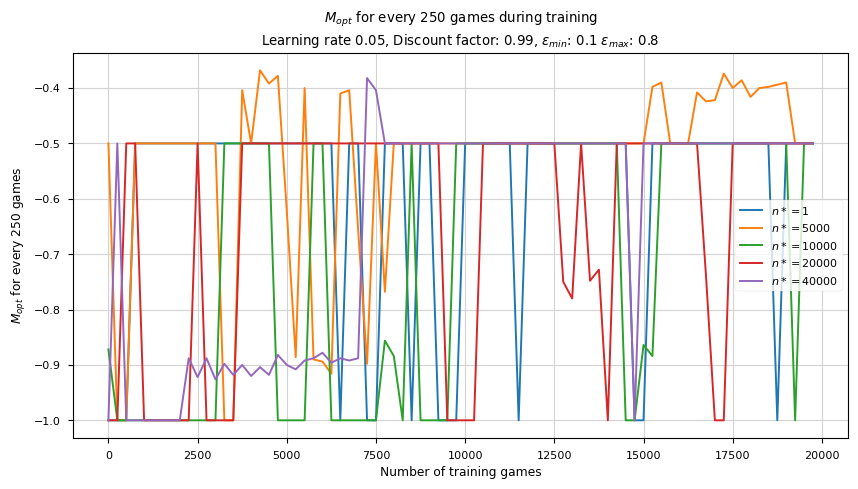

In [49]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')
plt.figure(figsize=(10, 5))
for n_star, m_opt_list in sorted(m_opt_dict.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_opt_list, "-", label=f"$n*={n_star}$")
plt.title("$M_{opt}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f},"+" $\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{opt}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()

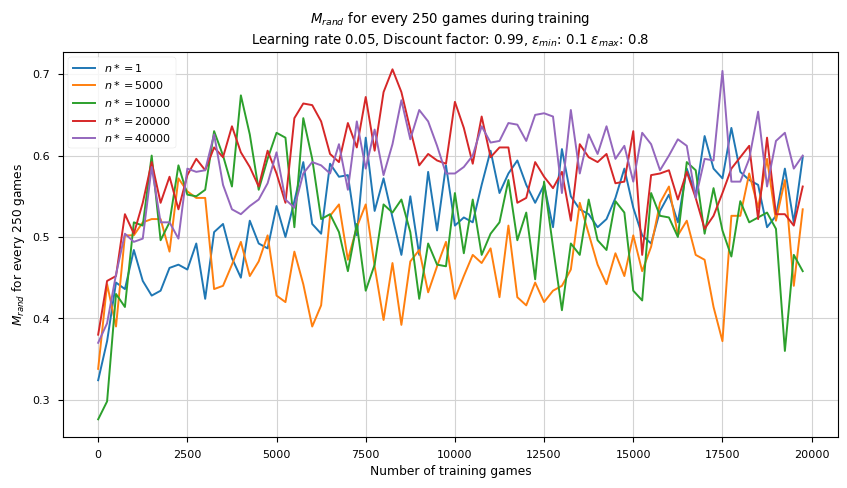

In [50]:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-paper')

plt.figure(figsize=(10, 5))
for n_star, m_rand_list in sorted(m_rand_dict.items()):
    plt.plot(np.arange(0, num_trained_games, 250), m_rand_list, "-", label=f"$n*={n_star}$")
plt.title("$M_{rand}$" + f" for every 250 games during training\nLearning rate {alpha:.2f}, Discount factor: {gamma:.2f},"+" $\epsilon_{min}$: "+str(epsilon_min)+" $\epsilon_{max}$: "+str(epsilon_max))
plt.ylabel("$M_{rand}$ for every 250 games")
plt.xlabel("Number of training games")
plt.legend()
plt.grid(color="lightgrey")
plt.show()